1. 데이터 준비   
 1.1 csv데이터   


In [1]:
# PATH변경
import pandas as pd
label_df = pd.read_csv('./Dataset/train.csv')
label_df.head()

,file_name,label
0,001.PNG,9
1,002.PNG,4
2,003.PNG,1
3,004.PNG,1
4,005.PNG,6


 1.2 이미지 데이터

In [2]:
import os
from glob import glob

def get_train_data(data_dir):
    img_path_list = []
    label_list = []

    # get image path
    img_path_list.extend(glob(os.path.join(data_dir, '*.PNG')))
    #print(glob(os.path.join(data_dir,'*.PNG')))
    # /로 짤린 것 중에서 맨 뒤( *.PNG) + 거기서 '.'으로 나뉘는 파일이름으로 정렬
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('.')[0]))

    # get label
    label_list.extend(label_df['label'])

    return img_path_list, label_list

def get_test_data(data_dir):
    img_path_list = []

    # get image path
    img_path_list.extend(glob(os.path.join(data_dir, '*.PNG')))
    img_path_list.sort(key=lambda x : int(x.split('/')[-1].split('.')[0]) )

    return img_path_list


2. 데이터 확인
 2. 1 csv 데이터

In [3]:
print(label_df.head())
label_df.info()


  file_name  label
0   001.PNG      9
1   002.PNG      4
2   003.PNG      1
3   004.PNG      1
4   005.PNG      6
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 723 entries, 0 to 722
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  723 non-null    object
 1   label      723 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.4+ KB


   2.2 이미지 데이터

In [4]:
all_img_path, all_label = get_train_data('./Dataset/train')
test_img_path = get_test_data('./Dataset/test')
print(all_img_path[:5])
print(all_label[:5])

['./Dataset/train/001.PNG', './Dataset/train/002.PNG', './Dataset/train/003.PNG', './Dataset/train/004.PNG', './Dataset/train/005.PNG']
[9, 4, 1, 1, 6]


3. 환경설정   
데이터를 전처리 하기 위한 GPU 환경설정

In [5]:
import torch
import torch.nn as nn
# 병렬화 비활성화
#os.environ["TOKENIZERS_PARALLELISM"] = "false"
# GPU를 정렬 , 0번 부터
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # Arrange GPU devices starting from 0
# 사용하고자 하는 GPU빼고 나머지 제한
#os.environ["CUDA_VISIBLE_DEVICES"] = "2" # Set the GPU 2 to us, multi gpu
GPU_NUM = 1 # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU
os.environ['CUDA_LAUNCH_BLOCKING']="1"
print(device)
print(f'torch version : {torch.__version__}')


cuda:1
torch version : 1.12.1


In [6]:
# GPU 체크 및 할당
if torch.cuda.is_available():
    print('Device :',device)
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU :', torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print('No GPU available, using the CPU instead.')

Device : cuda:1
There are 2 GPU(s) available.
We will use the GPU : NVIDIA GeForce RTX 3090 Ti


데이터 전처리   
CustomDataset

In [7]:
import torchvision.datasets as datasets # 데이터셋 
import torchvision.transforms as transforms # 이미지 변환 툴

from torch.utils.data import DataLoader # 학습 및 배치로 모델에 넣어주기 위한 툴
from torch.utils.data import Dataset

import cv2

class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True, transforms=None):
        self.transforms = transforms
        self.train_mode = train_mode
        self.img_path_list = img_path_list
        self.label_list = label_list

    def __getitem__(self,index):
        img_path = self.img_path_list[index]
        image = cv2.imread(img_path)
        if self.transforms is not None:
            image = self.transforms(image)
        
        if self.train_mode:
            label = self.label_list[index]
            return image, label
        else:
            return image

    def __len__(self):
        return len(self.img_path_list)

    

CustomDataset으로 만든 Data확인

In [8]:
temp_dataset = CustomDataset(all_img_path,all_label, train_mode=False)

<class 'numpy.ndarray'>


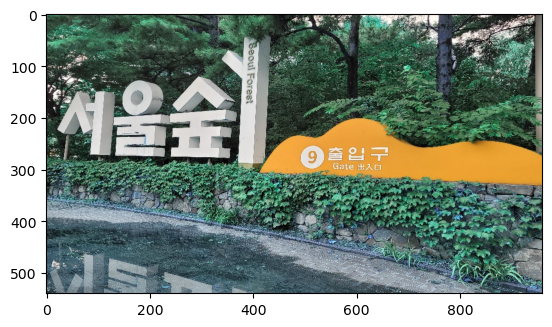

In [9]:
import matplotlib.pyplot as plt
print(type(temp_dataset.__getitem__(0)))
plt.imshow(temp_dataset.__getitem__(0))

전체 이미지 mean과 std 구하기

In [12]:
# 모든 이미지의 사이즈 확인
# mean과 std 구하기
import numpy as np
temp_transform = transforms.Compose([
    transforms.ToTensor(), # tensor로 변경
])
temp_dataset = CustomDataset(
    all_img_path,all_label, train_mode=False, transforms=temp_transform)

def find_info(dataset):
    img_size = []
    img_mean = np.empty((0,3))
    img_std = np.empty((0,3))
    #print(len(dataset)) -> 723개
    for i in range(len(dataset)):
        img = dataset.__getitem__(i)
        m = np.mean(np.array(img),axis=(1,2))
        s = np.std(np.array(img),axis=(1,2))
        img_mean = np.append(img_mean,[m],axis=0)
        img_std = np.append(img_std,[s],axis=0)
        #print(np.array(img).shape) # 3,540,960
        #print(img_mean.shape)      # (3,)
        #print(img_std.shape)       # (3,)

        if img.shape not in img_size:
            img_size.append(img.shape)
    #print(img_mean.shape)
    mean_r = round(np.mean(img_mean[:,0]),3)
    mean_g = round(np.mean(img_mean[:,1]),3)
    mean_b = round(np.mean(img_mean[:,2]),3)
    mean = (mean_r, mean_g, mean_b)
    
    std_r = round(np.mean(img_std[:,0]),3)
    std_g = round(np.mean(img_std[:,1]),3)
    std_b = round(np.mean(img_std[:,2]),3)
    std = (std_r,std_g,std_b)

    return img_size, mean, std

#img_size, img_mean, img_std = find_info(temp_dataset)
img_size = [[3,540,960]]
img_mean = (0.475, 0.470, 0.458)
img_std = (0.295, 0.264, 0.254)
print(f'img_size = {img_size}')
print(f'img mean = {img_mean}')
print(f'img std = {img_std}')


img_size = [[3, 540, 960]]
img mean = (0.475, 0.47, 0.458)
img std = (0.295, 0.264, 0.254)


Train / Validation split   
전체 데이터에서 분리

In [13]:
train_len = int(len(all_img_path)*0.75)
val_len = int(len(all_img_path)*0.25)

train_img_path = all_img_path[:train_len]
train_label = all_label[:train_len]

val_img_path = all_img_path[train_len:]
val_label = all_label[train_len:]

In [14]:
print(f'train set 크기 : {len(train_img_path)}')
print(f'val set 크기 : {len(val_img_path)}')

train set 크기 : 542
val set 크기 : 181


하이퍼 파라미터 값 설정

In [15]:
CFG = {
    'IMG_SIZE':512,
    'CROP_SIZE':384,
    'EPOCHS':200,
    'LEARNING_RATE':1e-2,
    'BATCH_SIZE':8,
}

Transform

In [16]:
train_transform = transforms.Compose([
    transforms.ToPILImage(), # numpy --> PIL로 변경
    transforms.Resize([CFG['CROP_SIZE'],CFG['CROP_SIZE']]), #128 * 128이미지로 사이즈변경
    #transforms.RandomCrop(CFG['CROP_SIZE']),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(20),
    transforms.ToTensor(), # tensor로 변경
    transforms.Normalize(mean=img_mean, std=img_std), # 이미지 정규화 
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize([CFG['CROP_SIZE'],CFG['CROP_SIZE']]),
    #transforms.RandomCrop(CFG['CROP_SIZE']),
    transforms.ToTensor(),
    transforms.Normalize(mean=img_mean, std=img_std),
])

DataLoader

In [17]:
train_dataset = CustomDataset(
    train_img_path, 
    train_label,
    train_mode=True,
    transforms=train_transform
    )
train_loader = DataLoader(
    train_dataset,
    batch_size = CFG['BATCH_SIZE'],
    shuffle=True,
    num_workers=0 # data로드를 위해 몇개의 서브 프로세스를 사용할지
)

val_dataset = CustomDataset(
    val_img_path,
    val_label,
    train_mode=True,
    transforms=test_transform
)
val_loader = DataLoader(
    val_dataset,
    batch_size = CFG['BATCH_SIZE'],
    shuffle=False,
    num_workers=0
)

In [18]:
train_batches = len(train_loader)
val_batches = len(val_loader)

print(f'total train imgs : {train_len} / total train batches :{train_batches}')
print(f'total val imgs : {val_len} / total val batches :{val_batches}')

total train imgs : 542 / total train batches :68
total val imgs : 180 / total val batches :23


Model 정의

In [19]:
import torch.nn as nn

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, block=Bottleneck, layers=[3, 4, 6, 3], num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1

        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation

        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [20]:
resnet50 = ResNet(num_classes=10, norm_layer=True)
resnet101 = ResNet(layers=[3, 4, 23, 3], num_classes=10, norm_layer=True)

TypeError: 'bool' object is not callable

In [17]:
from torchvision import models
from torchvision.models import efficientnet_b3 
import torch.nn as nn
from torch.nn import functional as F

effi_net = models.efficientnet_b7(pretrained=False)

print(effi_net.classifier)

in_eff = 2560

e_classifier=nn.Sequential(
    nn.Linear(in_eff,1000),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1000,10),

)
# 기본 모델은 fc 마지막이 1000개의 분류 , 맞춰주어야한다
effi_net.classifier = e_classifier


Sequential(
  (0): Dropout(p=0.5, inplace=True)
  (1): Linear(in_features=2560, out_features=1000, bias=True)
)


Model 학습

In [19]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=effi_net.parameters(), lr=CFG['LEARNING_RATE'],momentum=0.9)
scheduler = None
#scheduler=torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10,T_mult=2)

In [20]:
from tqdm import tqdm

def train(model,optimizer, train_loader, scheduler,device,name):
    model.to(device)
    n = len(train_loader)
    best_acc = 0
    count = 1
    best_loss = 100
    history = {}
    history['train_loss'] =[]
    history['train_acc'] = []
    history['val_loss'] = []
    history['val_acc'] = []
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        running_loss = 0.0

        for img, label in tqdm(iter(train_loader)):
            img, label = img.to(device), label.to(device)
            optimizer.zero_grad()

            output = model(img)
            loss = criterion(output,label)

            loss.backward()
            optimizer.step()
            running_loss +=loss.item()
        print(f'{epoch} Train loss : {running_loss/len(train_loader):.5f}')

        if scheduler is not None:
            scheduler.step()

        model.eval()
        val_loss = 0.0
        correct = 0
        with torch.no_grad():
            for img, label in tqdm(iter(val_loader)):
                img, label = img.to(device), label.to(device)

                output = model(img)
                val_loss += criterion(output,label)
                # 가장 높은 것을 예측
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(label.view_as(pred)).sum().item()
        val_acc = 100* correct / len(val_loader.dataset)
        print(f'Val loss : {val_loss/len(val_loader):.4f}, Acc : {correct}/{len(val_loader.dataset)} :{100*correct/len(val_loader.dataset):.1f}')
        history['train_loss'].append(running_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)
        # best 모델 저장
        #if best_acc < val_acc:
        #    best_acc = val_acc
        #    torch.save(model.state_dict(),'save_model/best_model.pth')
        #    print('Model Saved')
        # 5번 연속으로 개선이 없으면 멈추기
        if best_acc > val_acc:
            if count > 5:
                print('Early stopping')
                break
            count +=1
        else:
            best_acc = val_acc
            if best_loss > val_loss:
                torch.save(model.state_dict(),f'checkpoint/best_{name}.pth')
                print('Model Saved')

                best_loss = val_loss
                count = 1
    return history

In [21]:
print(os.getcwd())
print(os.path.isdir('checkpoint'))
e_history =train(effi_net, optimizer, train_loader, scheduler, device, 'efficient')


/workspace/Torch/dacon/Basic_landmark
True


100%|██████████| 68/68 [00:38<00:00,  1.78it/s]


1 Train loss : 1.81353


100%|██████████| 23/23 [00:06<00:00,  3.79it/s]


Val loss : 1.0493, Acc : 139/181 :76.8
Model Saved


100%|██████████| 68/68 [00:36<00:00,  1.84it/s]


2 Train loss : 0.50251


100%|██████████| 23/23 [00:06<00:00,  3.75it/s]


Val loss : 0.1920, Acc : 175/181 :96.7
Model Saved


100%|██████████| 68/68 [00:36<00:00,  1.86it/s]


3 Train loss : 0.15113


100%|██████████| 23/23 [00:06<00:00,  3.48it/s]


Val loss : 0.0835, Acc : 177/181 :97.8
Model Saved


100%|██████████| 68/68 [00:36<00:00,  1.85it/s]


4 Train loss : 0.04018


100%|██████████| 23/23 [00:06<00:00,  3.77it/s]


Val loss : 0.0478, Acc : 179/181 :98.9
Model Saved


100%|██████████| 68/68 [00:37<00:00,  1.84it/s]


5 Train loss : 0.05740


100%|██████████| 23/23 [00:06<00:00,  3.78it/s]


Val loss : 0.0255, Acc : 180/181 :99.4
Model Saved


100%|██████████| 68/68 [00:36<00:00,  1.84it/s]


6 Train loss : 0.04403


100%|██████████| 23/23 [00:06<00:00,  3.78it/s]


Val loss : 0.0414, Acc : 180/181 :99.4


100%|██████████| 68/68 [00:36<00:00,  1.84it/s]


7 Train loss : 0.02708


100%|██████████| 23/23 [00:06<00:00,  3.81it/s]


Val loss : 0.0588, Acc : 178/181 :98.3


100%|██████████| 68/68 [00:36<00:00,  1.85it/s]


8 Train loss : 0.01697


100%|██████████| 23/23 [00:06<00:00,  3.79it/s]


Val loss : 0.0277, Acc : 180/181 :99.4


100%|██████████| 68/68 [00:37<00:00,  1.84it/s]


9 Train loss : 0.03362


100%|██████████| 23/23 [00:06<00:00,  3.80it/s]


Val loss : 0.0330, Acc : 180/181 :99.4


100%|██████████| 68/68 [00:37<00:00,  1.84it/s]


10 Train loss : 0.01908


100%|██████████| 23/23 [00:06<00:00,  3.78it/s]


Val loss : 0.0305, Acc : 179/181 :98.9


100%|██████████| 68/68 [00:37<00:00,  1.82it/s]


11 Train loss : 0.01496


100%|██████████| 23/23 [00:06<00:00,  3.79it/s]


Val loss : 0.0258, Acc : 179/181 :98.9


100%|██████████| 68/68 [00:37<00:00,  1.81it/s]


12 Train loss : 0.01983


100%|██████████| 23/23 [00:06<00:00,  3.76it/s]


Val loss : 0.0566, Acc : 177/181 :97.8


100%|██████████| 68/68 [00:37<00:00,  1.84it/s]


13 Train loss : 0.01156


100%|██████████| 23/23 [00:06<00:00,  3.79it/s]


Val loss : 0.0299, Acc : 180/181 :99.4


100%|██████████| 68/68 [00:36<00:00,  1.84it/s]


14 Train loss : 0.01214


100%|██████████| 23/23 [00:06<00:00,  3.79it/s]


Val loss : 0.0247, Acc : 178/181 :98.3


100%|██████████| 68/68 [00:36<00:00,  1.84it/s]


15 Train loss : 0.00669


100%|██████████| 23/23 [00:06<00:00,  3.79it/s]


Val loss : 0.0144, Acc : 180/181 :99.4
Model Saved


100%|██████████| 68/68 [00:36<00:00,  1.84it/s]


16 Train loss : 0.00843


100%|██████████| 23/23 [00:06<00:00,  3.80it/s]


Val loss : 0.0218, Acc : 179/181 :98.9


100%|██████████| 68/68 [00:37<00:00,  1.84it/s]


17 Train loss : 0.00544


100%|██████████| 23/23 [00:06<00:00,  3.76it/s]


Val loss : 0.0180, Acc : 180/181 :99.4


100%|██████████| 68/68 [00:37<00:00,  1.82it/s]


18 Train loss : 0.00774


100%|██████████| 23/23 [00:06<00:00,  3.76it/s]


Val loss : 0.0285, Acc : 179/181 :98.9


100%|██████████| 68/68 [00:37<00:00,  1.80it/s]


19 Train loss : 0.00858


100%|██████████| 23/23 [00:06<00:00,  3.79it/s]


Val loss : 0.0272, Acc : 179/181 :98.9


100%|██████████| 68/68 [00:37<00:00,  1.83it/s]


20 Train loss : 0.00966


100%|██████████| 23/23 [00:06<00:00,  3.79it/s]


Val loss : 0.0166, Acc : 180/181 :99.4


100%|██████████| 68/68 [00:36<00:00,  1.84it/s]


21 Train loss : 0.02323


100%|██████████| 23/23 [00:06<00:00,  3.79it/s]


Val loss : 0.0273, Acc : 179/181 :98.9


100%|██████████| 68/68 [00:36<00:00,  1.84it/s]


22 Train loss : 0.00219


100%|██████████| 23/23 [00:06<00:00,  3.78it/s]


Val loss : 0.0236, Acc : 179/181 :98.9


100%|██████████| 68/68 [00:37<00:00,  1.83it/s]


23 Train loss : 0.00796


100%|██████████| 23/23 [00:06<00:00,  3.79it/s]

Val loss : 0.0330, Acc : 178/181 :98.3
Early stopping


In [22]:
r_50_history=train(resnet50,optimizer,train_loader, scheduler, device, 'resnet50')


100%|██████████| 68/68 [00:37<00:00,  1.81it/s]


1 Train loss : 0.00830


100%|██████████| 23/23 [00:06<00:00,  3.76it/s]


Val loss : 0.0268, Acc : 179/181 :98.9
Model Saved


100%|██████████| 68/68 [00:37<00:00,  1.82it/s]


2 Train loss : 0.01852


100%|██████████| 23/23 [00:06<00:00,  3.77it/s]


Val loss : 0.0225, Acc : 179/181 :98.9
Model Saved


100%|██████████| 68/68 [00:37<00:00,  1.83it/s]


3 Train loss : 0.00403


100%|██████████| 23/23 [00:06<00:00,  3.79it/s]


Val loss : 0.0215, Acc : 180/181 :99.4
Model Saved


100%|██████████| 68/68 [00:36<00:00,  1.84it/s]


4 Train loss : 0.00806


100%|██████████| 23/23 [00:06<00:00,  3.79it/s]


Val loss : 0.0219, Acc : 179/181 :98.9


100%|██████████| 68/68 [00:37<00:00,  1.80it/s]


5 Train loss : 0.00519


100%|██████████| 23/23 [00:06<00:00,  3.79it/s]


Val loss : 0.0163, Acc : 179/181 :98.9


100%|██████████| 68/68 [00:36<00:00,  1.84it/s]


6 Train loss : 0.00877


100%|██████████| 23/23 [00:06<00:00,  3.79it/s]


Val loss : 0.0158, Acc : 180/181 :99.4
Model Saved


100%|██████████| 68/68 [00:36<00:00,  1.84it/s]


7 Train loss : 0.00321


100%|██████████| 23/23 [00:06<00:00,  3.79it/s]


Val loss : 0.0326, Acc : 178/181 :98.3


100%|██████████| 68/68 [00:37<00:00,  1.82it/s]


8 Train loss : 0.01333


100%|██████████| 23/23 [00:06<00:00,  3.80it/s]


Val loss : 0.0195, Acc : 180/181 :99.4


100%|██████████| 68/68 [00:37<00:00,  1.82it/s]


9 Train loss : 0.02342


100%|██████████| 23/23 [00:06<00:00,  3.79it/s]


Val loss : 0.0138, Acc : 181/181 :100.0
Model Saved


100%|██████████| 68/68 [00:37<00:00,  1.82it/s]


10 Train loss : 0.01801


100%|██████████| 23/23 [00:06<00:00,  3.80it/s]


Val loss : 0.0224, Acc : 180/181 :99.4


100%|██████████| 68/68 [00:37<00:00,  1.83it/s]


11 Train loss : 0.01339


100%|██████████| 23/23 [00:06<00:00,  3.78it/s]


Val loss : 0.0097, Acc : 181/181 :100.0
Model Saved


100%|██████████| 68/68 [00:37<00:00,  1.83it/s]


12 Train loss : 0.02896


100%|██████████| 23/23 [00:06<00:00,  3.80it/s]


Val loss : 0.0207, Acc : 179/181 :98.9


100%|██████████| 68/68 [00:37<00:00,  1.83it/s]


13 Train loss : 0.00924


100%|██████████| 23/23 [00:06<00:00,  3.80it/s]


Val loss : 0.0233, Acc : 180/181 :99.4


100%|██████████| 68/68 [00:37<00:00,  1.81it/s]


14 Train loss : 0.00252


100%|██████████| 23/23 [00:06<00:00,  3.79it/s]


Val loss : 0.0117, Acc : 181/181 :100.0


100%|██████████| 68/68 [00:36<00:00,  1.84it/s]


15 Train loss : 0.02706


100%|██████████| 23/23 [00:06<00:00,  3.78it/s]


Val loss : 0.0067, Acc : 181/181 :100.0
Model Saved


100%|██████████| 68/68 [00:36<00:00,  1.84it/s]


16 Train loss : 0.02134


100%|██████████| 23/23 [00:06<00:00,  3.77it/s]


Val loss : 0.0145, Acc : 180/181 :99.4


100%|██████████| 68/68 [00:36<00:00,  1.84it/s]


17 Train loss : 0.00328


100%|██████████| 23/23 [00:06<00:00,  3.80it/s]


Val loss : 0.0287, Acc : 179/181 :98.9


100%|██████████| 68/68 [00:36<00:00,  1.84it/s]


18 Train loss : 0.00516


100%|██████████| 23/23 [00:06<00:00,  3.79it/s]


Val loss : 0.0211, Acc : 180/181 :99.4


100%|██████████| 68/68 [00:37<00:00,  1.84it/s]


19 Train loss : 0.00881


100%|██████████| 23/23 [00:06<00:00,  3.80it/s]


Val loss : 0.0107, Acc : 180/181 :99.4


100%|██████████| 68/68 [00:37<00:00,  1.82it/s]


20 Train loss : 0.00718


100%|██████████| 23/23 [00:06<00:00,  3.76it/s]


Val loss : 0.0196, Acc : 180/181 :99.4


100%|██████████| 68/68 [00:36<00:00,  1.84it/s]


21 Train loss : 0.01044


100%|██████████| 23/23 [00:06<00:00,  3.80it/s]

Val loss : 0.0250, Acc : 180/181 :99.4
Early stopping


In [ ]:
r_101_history=train(resnet101,optimizer,train_loader, scheduler, device, 'resnet101')


예측하기

In [36]:
def predict(model,model2,model3, test_loader, device):
    model.to(device)
    model2.to(device)
    model3.to(device)
    model.eval()
    model2.eval()
    model3.eval()
    model_pred = []
    with torch.no_grad():
        for img in tqdm(iter(test_loader)):
            img = img.to(device)

            output1 = model(img)
            output2 = model2(img)
            output3 = model3(img)
            print(output1.shape, output2.shape, output3.shape)
            pred_output = F.softmax(output1,dim=1)+F.softmax(output2,dim=1)+F.softmax(output3,dim=1)
            pred_output = pred_output.argmax(dim=1, keepdim=True).squeeze(1)

            model_pred.extend(pred_output.tolist())
    return model_pred

In [37]:
test_dataset = CustomDataset(test_img_path,None,train_mode=False,transforms=test_transform)
test_loader= DataLoader(test_dataset,batch_size =CFG['BATCH_SIZE'],shuffle=False,num_workers=0)

checkpoint = torch.load('checkpoint/best_efficient.pth')
model.load_state_dict(checkpoint, strict=False)

checkpoint = torch.load('checkpoint/best_resnet50.pth')
resnet50.load_state_dict(checkpoint, strict=False)

checkpoint = torch.load('checkpoint/best_resnet101.pth')
resnet101.load_state_dict(checkpoint, strict=False)

preds = predict(model,resnet101,resnet50,test_loader,device)
preds[0:5]

  4%|▍         | 1/25 [00:00<00:08,  2.93it/s]

torch.Size([8, 10]) torch.Size([8, 10]) torch.Size([8, 10])


  8%|▊         | 2/25 [00:00<00:07,  3.08it/s]

torch.Size([8, 10]) torch.Size([8, 10]) torch.Size([8, 10])


 12%|█▏        | 3/25 [00:00<00:07,  3.09it/s]

torch.Size([8, 10]) torch.Size([8, 10]) torch.Size([8, 10])


 16%|█▌        | 4/25 [00:01<00:06,  3.10it/s]

torch.Size([8, 10]) torch.Size([8, 10]) torch.Size([8, 10])


 20%|██        | 5/25 [00:01<00:06,  3.08it/s]

torch.Size([8, 10]) torch.Size([8, 10]) torch.Size([8, 10])


 24%|██▍       | 6/25 [00:01<00:06,  3.09it/s]

torch.Size([8, 10]) torch.Size([8, 10]) torch.Size([8, 10])


 28%|██▊       | 7/25 [00:02<00:05,  3.07it/s]

torch.Size([8, 10]) torch.Size([8, 10]) torch.Size([8, 10])


 32%|███▏      | 8/25 [00:02<00:05,  3.07it/s]

torch.Size([8, 10]) torch.Size([8, 10]) torch.Size([8, 10])


 36%|███▌      | 9/25 [00:02<00:05,  3.05it/s]

torch.Size([8, 10]) torch.Size([8, 10]) torch.Size([8, 10])


 40%|████      | 10/25 [00:03<00:04,  3.05it/s]

torch.Size([8, 10]) torch.Size([8, 10]) torch.Size([8, 10])


 44%|████▍     | 11/25 [00:03<00:04,  3.05it/s]

torch.Size([8, 10]) torch.Size([8, 10]) torch.Size([8, 10])


 48%|████▊     | 12/25 [00:03<00:04,  3.04it/s]

torch.Size([8, 10]) torch.Size([8, 10]) torch.Size([8, 10])


 52%|█████▏    | 13/25 [00:04<00:03,  3.05it/s]

torch.Size([8, 10]) torch.Size([8, 10]) torch.Size([8, 10])


 56%|█████▌    | 14/25 [00:04<00:03,  3.04it/s]

torch.Size([8, 10]) torch.Size([8, 10]) torch.Size([8, 10])


 60%|██████    | 15/25 [00:04<00:03,  3.03it/s]

torch.Size([8, 10]) torch.Size([8, 10]) torch.Size([8, 10])


 64%|██████▍   | 16/25 [00:05<00:02,  3.03it/s]

torch.Size([8, 10]) torch.Size([8, 10]) torch.Size([8, 10])


 68%|██████▊   | 17/25 [00:05<00:02,  2.99it/s]

torch.Size([8, 10]) torch.Size([8, 10]) torch.Size([8, 10])


 72%|███████▏  | 18/25 [00:05<00:02,  2.91it/s]

torch.Size([8, 10]) torch.Size([8, 10]) torch.Size([8, 10])


 76%|███████▌  | 19/25 [00:06<00:01,  3.00it/s]

torch.Size([8, 10]) torch.Size([8, 10]) torch.Size([8, 10])


 80%|████████  | 20/25 [00:06<00:01,  3.03it/s]

torch.Size([8, 10]) torch.Size([8, 10]) torch.Size([8, 10])


 84%|████████▍ | 21/25 [00:06<00:01,  3.03it/s]

torch.Size([8, 10]) torch.Size([8, 10]) torch.Size([8, 10])


 88%|████████▊ | 22/25 [00:07<00:00,  3.03it/s]

torch.Size([8, 10]) torch.Size([8, 10]) torch.Size([8, 10])


 92%|█████████▏| 23/25 [00:07<00:00,  3.06it/s]

torch.Size([8, 10]) torch.Size([8, 10]) torch.Size([8, 10])


 96%|█████████▌| 24/25 [00:07<00:00,  3.06it/s]

torch.Size([8, 10]) torch.Size([8, 10]) torch.Size([8, 10])


100%|██████████| 25/25 [00:08<00:00,  3.06it/s]

torch.Size([7, 10]) torch.Size([7, 10]) torch.Size([7, 10])


[7, 1, 9, 7, 6]

submission 파일 생성

In [38]:
submission = pd.read_csv('Dataset/sample_submission.csv')
submission['label'] = preds
submission.to_csv('checkpoint/submission_final.csv',index=False)

In [35]:
def predict(model, test_loader, device):
    model.eval()
    model_pred = []
    with torch.no_grad():
        for img in tqdm(iter(test_loader)):
            img = img.to(device)

            pred_output = model(img)
            pred_output = pred_output.argmax(dim=1, keepdim=True).squeeze(1)

            model_pred.extend(pred_output.tolist())
    return model_pred
test_dataset = CustomDataset(test_img_path,None,train_mode=False,transforms=test_transform)
test_loader= DataLoader(test_dataset,batch_size =CFG['BATCH_SIZE'],shuffle=False,num_workers=0)

checkpoint = torch.load('checkpoint/best_resnet50.pth')
resnet50.load_state_dict(checkpoint, strict=False)

submission = pd.read_csv('Dataset/sample_submission.csv')
submission['label'] = preds
submission.to_csv('checkpoint/submission_resnet50.csv',index=False)